# Module 4: Image Processing
---
## Introduction
In Module 3, we studied the different ways we could decrypt messages encrypted with the Caesar and Affine cipher. In this module, we'll take a look at steganography--the technique of hiding secret data within an ordinary, public file to avoid detection. We'll explore this approach through hiding messages within images, and using CUDA to encrypt and decrypt such messages.

This assignment will cover:

* Image processing basics
* Steganography with images
---
## Assignment
There are two parts to this assignmnt:

* Part 1 -- Fun with Filters
* Part 2 -- Image Steganography
---
## Module Learning Objectives
* Write CUDA kernels that implement different filters of an image
* Use PPM format to store/modify images
* Encode and decode messages stored as pixel values within each image
* Performing bitwise operations to manipulate data

### Preliminaries

Before you dive in to Module 4, we need to:  
* Install our CUDA plugin and load it into Colab
* Clone the GitHub repository for course materials
* Figure out the correct compute capability for our GPU

Run the following cells:

In [1]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-__444euq
  Running command git clone -q git://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-__444euq
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4305 sha256=2689bedcb4a6454c5fc3a80e79b4d1492a4dbf6746b1c8a9946e15dc8acb4b93
  Stored in directory: /tmp/pip-ephem-wheel-cache-1jesv2by/wheels/c5/2b/c0/87008e795a14bbcdfc7c846a00d06981916331eb980b6c8bdf
Successfully built NVCCPlugin


In [2]:
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


In [3]:
!nvidia-smi

Tue Nov 23 09:51:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

| GPU      | Compute Capability | `-arch flag` |
| :-----------: | :-----------: | :-----------: |
| Tesla K80 | 3.7 | `-arch=sm_37` |
| NVIDIA T4 | 7.5 | `-arch=sm_75`   |
| NVIDIA P4 | 6.1 | `-arch=sm_61` |
| NVIDIA P100 | 6.0 | `-arch=sm_60`|

**Be sure to note down your compute capability for your GPU!**

In [4]:
!git clone https://github.com/rahultoppur/CUDA

Cloning into 'CUDA'...
remote: Enumerating objects: 389, done.
remote: Counting objects: 100% (389/389), done.
remote: Compressing objects: 100% (269/269), done.
remote: Total 389 (delta 172), reused 254 (delta 83), pack-reused 0
Receiving objects: 100% (389/389), 4.44 MiB | 13.82 MiB/s, done.
Resolving deltas: 100% (172/172), done.


Great! Now that we have that out of the way, let's jump into Module 4!

## Part 1: Fun with filters

### Introduction

In this assignment, we'll learn some different ways to manipulate images. Specifically, we will implement features such as: grayscale, increasing brightness, and filters.

### Portable Pixmap Format (PPM)


When interacting with our images, we are going to be using the PPM format. Some useful code has been provided for you in the common directory to load and save these types of images. You can learn more about what each value in the file represents here. Use display <filename> to view your images.

### RGB, Row-Major Revisited, and Parallelization Idea


In images, every pixel is comprised of 3 color components--Red, Green, and Blue. Each 8-bit value ranges from `[0,255]`, and different combinations of R,G,B make different colors.

When working with images, we now work in two dimensions (similar to matrix addition in Module 2). Each thread that we spawn is responsible for performing operations on a certain pixel `(x,y)` in our image.

Recall that in **C** our memory is stored in row-major order. So, we need to make sure we operate in "chunks" of 3, since we will operate on the R,G,B values for each pixel.

> Assume an `(x,y)` coordinate corresponds to a specific pixel, where `x` is the row, `y` is the column, and `w` is the width. Write an expression to get the index of the pixel (assuming row-major order) in an array (the offset).\
**TODO: Your answer here**

> Assume our image is loaded into a variable called `pixel_array`. Write an expression to get the `r`, `g`, and `b` value for an arbitrary pixel `p`. **Hint**: we need to use the `offset` we calculated in the previous question, and remember that we operate in "chunks" of 3.\
`r` =  **TODO: Your answer here**\
`g` =  **TODO: Your answer here** \
`b` =  **TODO: Your answer here** 

### Hints

* Introduce "clipping" for your pixel values. Introduce a maximum threshold so values can't exceed the upper limit for a valid value.
* Look the the `/content/CUDA/common/include/ppm.h` file for helpful functions to interact with PPM images.
* The questions you answered above will help you!



Some starter code has been provided. For each different filter operation below, write a new kernel call. In each task, load `safari.ppm` as your image. Save each altered image into this directory with the given filename. 

To keep things simple, launch `P` blocks, each with a single thread (where `P` is the total number values you need to keep track of for the image).

### Displaying PPM images (`display_PPM`)
Use the function defined below (`display_PPM`) to view PPM images within Colab. Just open up a new cell and specify the filename of your PPM image.

In [6]:
import cv2;
import matplotlib.pyplot as plt

def display_PPM(filepath):
  img = cv2.imread(filepath)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)

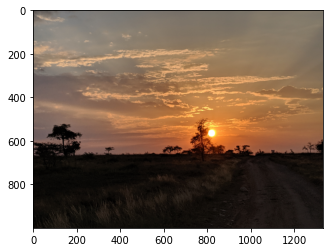

In [7]:
display_PPM("/content/CUDA/module_4_images/filters/safari.ppm")

In [ ]:
%%cuda --name filter.cu

#include <stdio.h>
#include <stdlib.h>
#include "/content/CUDA/common/include/ppm.h"   

/*
 * Compile with: !nvcc ./src/filter.cu /content/CUDA/common/src/ppm.cu -I/content/CUDA/common/include -o filter -arch=sm_37
 * Run with: !./filter
 * 
 * (You might have to change your -arch flag based on the GPU Google gives you)
 */

__global__ void make_grayscale(unsigned char* pixel_array, int width, int height)
{
    /* The (x,y) coordinate within the image */
    int x = /*...TODO...*/
    int y = /*...TODO...*/

    /* Bounds check to ensure threads are within image dimensions */
    if (x < width && y < height) {
        int offset = /*...TODO...*/

        /* Extract pixel values, perform operations, modify pixel_array */
        unsigned char r = pixel_array[offset *(/*...TODO...*/)]
        ...

        /* Create our grayscale by transforming pixel values */
        unsigned char tr = /*...TODO...*/
        unsigned char tg = /*...TODO...*/
        unsigned char tb = /*...TODO...*/

        /* Introduce some clipping of pixel values here */

        /* Persist our changes to our pixel_array data */
        pixel_array[offset * (/*...TODO...*/)] = /*...TODO...*/
        ...
    }
}

int main() {
    const char* input = "/content/CUDA/module_4_images/filters/safari.ppm";
    /* Load our PPM Image */
    ppm_t* myImage = loadPPMImage(input);
    
    int numberOfPixels = myImage->width * myImage->height;
    int sizeOfDataInBytes = (numberOfPixels)
                            * (/*...TODO...*/)
                            * (sizeof(unsigned char));

    /* Allocate required memory */ 
    cudaMalloc(/*...TODO...*/);
    cudaMemcpy(/*...TODO...*/, myImage->pixels,/*...TODO...*/,cudaMemcpyHostToDevice);

    dim3 blocksPerGrid(1,1,1);
    dim3 threadsPerBlock(myImage->width * (/*...TODO...*/), myImage->height * (/*...TODO...*/));

    /* We need to pass in some pointer to our data that's on the GPU */
    make_grayscale<<< /*...TODO...*/,/*...TODO...*/ >>>(/*...TODO...*/);

    cudaMemcpy(myImage->pixels,/*...TODO...*/,/*...TODO...*/,cudaMemcpyDeviceToHost);
    cudaFree(/*...TODO...*/);

    const char* output = "safari-output.ppm";

    /* Save our PPM Image */
    savePPMImage(output, myImage);

    /* Free any remaining memory on the host */
    ...

    return 0;
}


'File written in /content/src/filter.cu'

Compile and run with:

In [ ]:
!nvcc ./src/filter.cu /content/CUDA/common/src/ppm.cu -I/content/CUDA/common/include -o filter -arch=sm_37

nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).


In [ ]:
!./filter

Width: 1333

### Task 1: No filter


Get `filter.cu` to cleanly compile. Save your image as `safari_base.ppm`.

### Task 2: Grayscale


Create a kernel `make_grayscale`. Use the following formula when finding values for your pixels:
```c
R = .21f*r + .71f*g + .07f*b
G = .21f*r + .71f*g + .07f*b
B = .21f*r + .71f*g + .07f*b
```
Save your altered image as `safari_grayscale.ppm`.

### Task 3: Varying Brightness


Create two kernels: `increase_brightness` and `decrease_brightness`. 
> What types of pixel values make a color brighter? What makes it darker?\
**TODO: Your answer here**

Save your altered image as `safari_brighter.ppm` and `safari_darker.ppm`, respectively.

### Task 4: Blue Filter

Create a kernel `make_blue`. Use the following formula when finding values for your pixels:
```c
R = .189f*r + .2f*g + .769f*b
G = .49f * R
B = .69f * R
```
Save your altered image as `safari_blue.ppm`.

### Tasks

* Finish implementing `filter.cu`.
    * Complete the accompanying kernel calls and call `display_PPM()` on each of the following pictures you create in a new cell on Colab. For example, `display_PPM("./safari_grayscale.ppm")`.
        * `safari_base.ppm`
        * `safari_grayscale.ppm`
        * `safari_brighter.ppm`, `safari_darker.ppm`
        * `safari_blue.ppm`

### Your Pictures!

In [ ]:
# Your calls to display_PPM() go here...

## Part 2: Image Steganography

### Introduction

You are a spy working for your nation's government. You are currently operating undercover in enemy territory, and need to find a way to communicate to your HQ back home. Sending letters and emails are too risky, so you decide on something else--image steganography. You decide that you will "hide" your message (encoded as bits) within the pixels of the image that you send.

### Methodology

Encryption
* Encode the message as `N` bits (every 8 bits represents an ASCII character)
* The `R` value of the first `N` pixels of the image will contain the secret message as the **least-significant** bit (right-most bit)

Decryption
* Retrieve the first `N` pixels from the image, noting down the last bit of the `R` value of each pixel
* Convert the bits back to ASCII


### Task 1: Find the Hidden Message


Armed with your new CUDA image processing skills, you now have the ability to hide your messages within images. You get the following message from a colleague in an email along with the following photo:
```txt
Hi!

I went on a really great hike the other day and took this photo.

There was some beautiful scenery, and we were outside for 177 minutes.

Best,
 X.

---
Attachment(1)-hike_sunset.ppm
---
```

You find it odd that your friend mentioned such a specific time frame. Using `177` as the length of the encoded message (in bits), write `steg_decrypt.cu` which outputs the hidden message from `hike-sunset.ppm`.

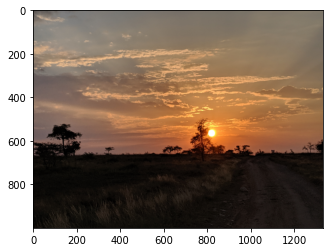

In [7]:
display_PPM("/content/CUDA/module_4_images/steganography/hike-sunset.ppm")

Some starter code for the kernel has been provided for you. 

```c
#define MSG_LEN 177

/* Decode the secret message embedded in our image */
__global__ void decode(unsigned char* pixel_array, int width, int height, char* msg) {
    /* Determine the (x,y) coordinate within our image */
    ...
    if (offset < MSG_LEN) {
      /* Obtain the last bit from the R value of each pixel */
    ...
    /* Write each portion of the secret message to msg */
    ...
    }
}
```

In [ ]:
%%cuda --name steg_decrypt.cu

#include <string.h>
#include <stdio.h>
#include <stdlib.h>
#include "/content/CUDA/common/include/ppm.h"

#define MSG_LEN 177

__global__ void decode(/*...TODO...*/)
{
    /*...TODO...*/
}

/* TODO */
int main()
{
    /* Remember that you now have an additional field you are
     * passing into your kernel, char* msg. Make sure you 
     * allocate memory and copy over a buffer to the GPU 
     * for you to write to!
     */
  
    const char* input = "/content/CUDA/module_4_images/steganography/hike-sunset.ppm"; 
    ppm_t* myImage = loadPPMImage(input);
 
    /*...TODO...*/

    /* Display the secret message */
 
    return 0;
}

Compile and run with:

In [ ]:
!nvcc ./src/steg_decrypt.cu /content/CUDA/common/src/ppm.cu -I/content/CUDA/common/include -o steg_decrypt -arch=sm_37

In [ ]:
!./steg_decrypt

Your program should output a string of bytes. Find the corresponding ASCII by using a tool like [this](https://www.rapidtables.com/convert/number/index.html). Be sure to convert to **ASCII** instead of **ASCII/UTF-8**.

> What was the hidden message?\
**TODO: Your answer here**

### Hints

* Your implementation from Part 1 of this assignment will be extremely useful for this section. In fact, only a few changes are required to implement Part 2 from Part 1.
* You'll have to perform a bit-wise operation in order to retrieve the last bit of the R value of each pixel.

### Task 2: Encrypting your own message


You want to reply to your friend's message. You can upload your own image by navigating to the "Files" tab in Colab on the left and selecting "Upload to session storage." 

With a picture of your choosing, encrypt the following message within your image:
```txt
msg:  bring me a shrubbery. one that looks nice and not too expensive.
```
Use this [tool](https://www.rapidtables.com/convert/number/index.html) to get the representation in bits. Implement `steg_encrypt.cu`, which encrypts `msg` into the image you selected. Name your kernel `encrypt`.



In [ ]:
%%cuda --name steg_encrypt.cu 

#include <string.h>
#include <stdio.h>
#include <stdlib.h>
#include "/content/CUDA/common/include/ppm.h"

#define MSG_LEN 177

__global__ void decode(/*...TODO...*/)
{
    /*...TODO...*/
}

/* TODO */
int main()
{
    /* Remember that you are now copying over your secret
     * message to the GPU--you will have to allocate 
     * memory accordingly! 
     */
    return 0;
}

Compile and run with:

In [ ]:
!nvcc ./src/steg_encrypt.cu /content/CUDA/common/src/ppm.cu -I/content/CUDA/common/include -o steg_encrypt -arch=sm_37

In [ ]:
!./steg_encrypt

Save your original image as `cool_pic_orig.ppm`. Save your encrypted message as `cool_pic_enc.ppm`. Call `display_PPM` on both of your images.


### Your two images here! (`cool_pic_orig.ppm` and `cool_pic_enc.ppm`)

In [8]:
# Your calls to display_PPM go here...

> Look at your pictures side by side. Can you spot any differences? **Why** do you think this is the case?\
**TODO: Your answer here**

### Hints

* Once again, you'll need to perform some bit-wise arithmetic in order to encode your message with the last bit of each R value.
* Think of two cases:
  * The least-significant-bit is a 0
  * The least-significant-bit is a 1
* Then, perform the appropriate operation to encode the specific bit of your secret message.

### Tasks

* Implement `steg-encrypt.cu` and `steg-decrypt.cu`
* Answer the **short answer questions** in Task 1 and Task 2

## All Done?
Navigate to `File` > `Download` > `Download .ipynb`. You can later submit this `.ipynb` file as an attachment after running each of your cells in the [Course Feedback survey](https://docs.google.com/forms/d/e/1FAIpQLSfAYjrJ04aurqE96z-OdUVWsLwdlq14oPKBUJRkShzfZtn6Gg/viewform).